In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Modelado

Cargamos los conjuntos de datos y librerías que se usarán en esta sección:

In [2]:
from utils.paths import crear_funcion_directorio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from utils.modeling import mostrar_podio_MVP
from utils.visualize import plotear_predvsreal
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from utils.modeling import calcular_importancia
from joblib import dump
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo los conjuntos de datos
df_data_jugadores_train = pd.read_csv(data_dir("processed", "df_data_jugadores_train.csv"))
X_train = pd.read_csv(data_dir("for_modeling", "X_train.csv"))
y_train = pd.read_csv(data_dir("for_modeling", "y_train.csv"))

## Random Forest

El modelo que hemos decidido utilizar es el **Random Forest**. Según nuestro criterio, este modelo es adecuado para evitar el **sobreajuste** y tiene la capacidad de generalizar bien con los datos disponibles. Además, es altamente útil para evaluar la **importancia** de cada atributo que utilizamos en el proceso de entrenamiento. Esto, a su vez, nos proporciona una comprensión más profunda de **cómo opera el premio** y los factores que influyen en él.

Antes de entrenar un modelo, estandarizamos los datos usando **StandardScaler**: 

In [3]:
#Genero un pipeline
pip = Pipeline([
 ('std_scaler', StandardScaler())
 ])

#Aplico la transformación
X_train_prepared = pip.fit_transform(X_train)

Usaremos **RandomizedSearchCV** para la búsqueda hiperparámetros, en principio tomamos una grilla extensa con la finalidad de que el modelo se ajuste de la mejor manera posible.

In [4]:
#Preparo la grilla de hipérparametros
param_grid = {
    'n_estimators': list(range(1, 1000)),
    'max_features': [1.0, 'sqrt'],
    'max_depth': list(range(1, 500)),
    'bootstrap': [True, False],
    'criterion': ['friedman_mse', 'absolute_error', 'poisson', 'squared_error'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

#Instancio un objeto tscv para mantener el orden con el tiempo
tscv = TimeSeriesSplit(n_splits=3)

#Hago la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grid, n_iter=100, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train_prepared, y_train.values.ravel())

#Me guardo al mejor estimador
forest_reg = random_search.best_estimator_

#Imprimo los hiperpárametros encontrados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

Mejores hiperparámetros encontrados: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 266, 'criterion': 'friedman_mse', 'bootstrap': True}


## Métricas: **mirando los números**

Observemos algunas métricas clásicas de regresión en nuestro modelo, así tendremos una idea apróximada de su comportamiento:

In [5]:
#Hago predicciones sobre los datos de entrenamiento
y_train_pred = forest_reg.predict(X_train_prepared)

#Observo las métricas
r2_train = r2_score(y_train, y_train_pred)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Métricas en el conjunto de entrenamiento:")
print(f"Coeficiente de determinación (R²): {r2_train:.4f}")
print(f"Varianza explicada: {explained_variance_train:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse_train:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_train:.4f}")

Métricas en el conjunto de entrenamiento:
Coeficiente de determinación (R²): 0.7279
Varianza explicada: 0.7280
MSE (Error Cuadrático Medio): 0.0107
RMSE (Raíz del Error Cuadrático Medio): 0.1033


Otra cualidad interesante y también una de las razones por las cuales escogimos el **Random Forest** es porque nos informa de que columnas **le resultaron más importantes**,
vamos a darle un vistazo:

In [16]:
calcular_importancia(set_entrenamiento= X_train, modelo= forest_reg)

,Feature,Importancia
3,ws,0.214259
7,vorp,0.212792
0,per,0.111993
4,ws_48,0.086709
2,dws,0.086354
8,fg_per_game,0.068295
9,pts_per_game,0.061481
6,bpm,0.058088
1,ows,0.053837
5,obpm,0.046192


## Métricas: **dándole el vistazo gráfico**

Los números nos dan una idea, pero observar el comportamiento del modelo **gráficamente** es una buena práctica para entender su comportamiento. Por lo tanto
procedemos a graficar la relación: **y_train vs y_train_pred**

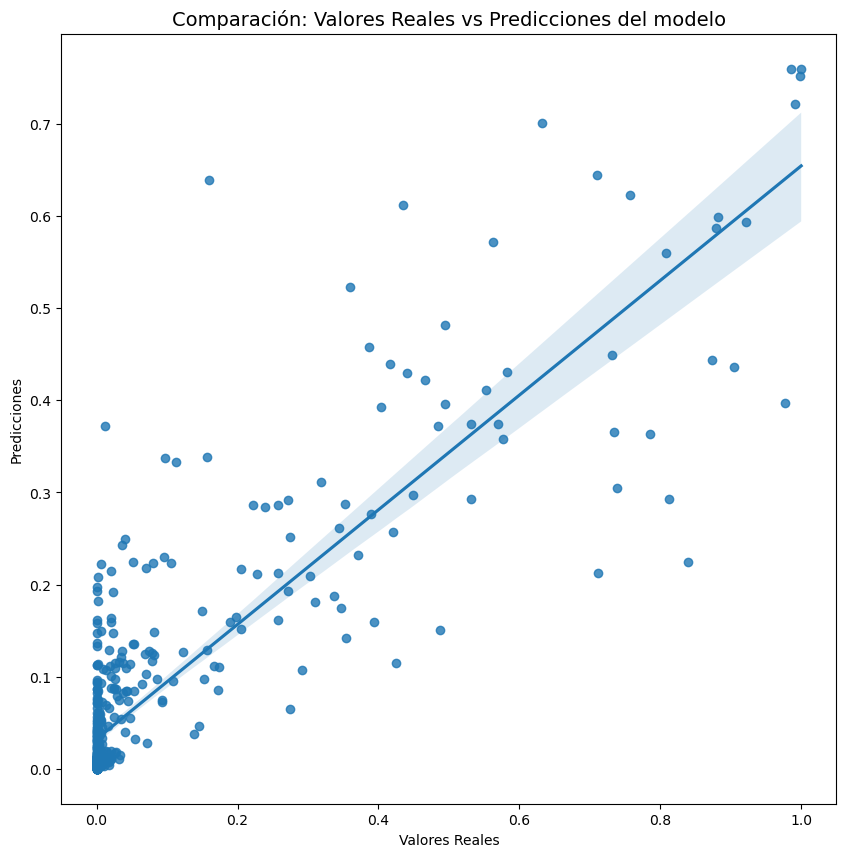

In [21]:
plotear_predvsreal(y_train, y_train_pred, tamanio= (10,10))

Gráficamente, evidenciamos que nuestro modelo se ajusta de **manera precisa** a los datos de entrenamiento, como habíamos observado al analizar las métricas. Además, **el ajuste no es excesivamente pronunciado**, indicando que el modelo no sobreajusta nuestros datos. Esta observación es satisfactoria, ya que sugiere que estamos frente a un modelo aceptable.

## Métricas: **Armando podios**

Finalmente, una **"métrica"** que se ajusta bastante bien a nuestro problema consiste en lo siguiente:

* Tomar las predicciones hechas por el modelo y observar **temporada por temporada**
* Ver que el modelo **ubique correctamente a los jugadores** en el podio, para nuestro problema nos importa más ese aspecto
  a que indique la proporción de votos con total precisión


In [7]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2011, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
43,2011,Derrick Rose,0.977,0.396847
157,2011,Dwight Howard,0.531,0.374262
210,2011,Dwyane Wade,0.020,0.163826
294,2011,Kobe Bryant,0.354,0.142255
85,2011,Kevin Durant,0.157,0.128833


In [8]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2014, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
82,2014,Kevin Durant,0.986,0.760100
89,2014,Kevin Love,0.020,0.214546
12,2014,Blake Griffin,0.347,0.174251
186,2014,Joakim Noah,0.258,0.160993
136,2014,Stephen Curry,0.053,0.135408


In [9]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2016, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
134,2016,Stephen Curry,1.000,0.759495
73,2016,Kawhi Leonard,0.484,0.372384
80,2016,Kevin Durant,0.112,0.332738
123,2016,Russell Westbrook,0.371,0.231568
20,2016,Chris Paul,0.082,0.123919


In [10]:
mostrar_podio_MVP(df_base= df_data_jugadores_train, columna_temporadas= 'season', columna_nombre= 'player', columna_votos= 'mvp_share', temporada= 2017, y_pred= y_train_pred, cant_jugadores= 5)

,season,player,mvp_share,y_pred
122,2017,Russell Westbrook,0.879,0.587612
72,2017,Kawhi Leonard,0.495,0.395735
162,2017,Isaiah Thomas,0.080,0.223040
4,2017,Anthony Davis,0.002,0.208177
79,2017,Kevin Durant,0.002,0.182615


De esta evaluación resaltamos lo siguiente:

* Aunque existe cierta diferencia entre **'mvp_share'** y **'y_pred'**, nuestro modelo **logró acertar al ganador del premio en cada temporada**
* Hay que recordar que hay **5 jugadores los cuales fueron sacados del conjunto de entrenamiento**, por lo tanto es normal que en sus años de ganar el premio
  el modelo los cambie por otro jugador
* Hay que recordar que esto **recién es el entrenamiento**, la prueba real se realizará en los datos de prueba, sin embargo estos resultados nos van dejando ver las capacidades de nuestro modelo

A continuación dejamos una tabla con los últimos ganadores para que puedan verificar a [los últimos ganadores](https://www.hispanosnba.com/historia/premios/mvp-nba):

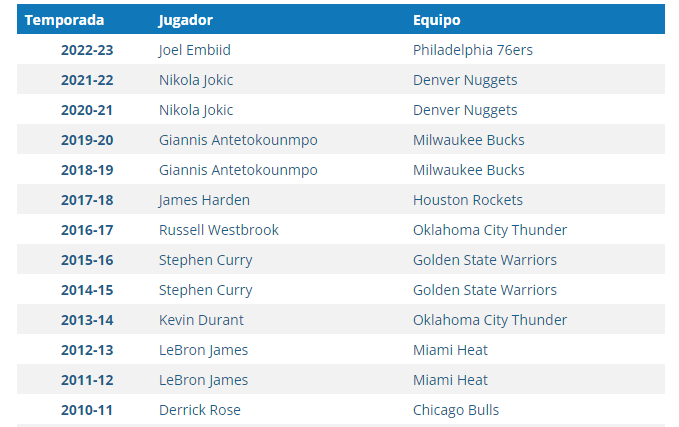

Finalmente, guardamos el modelo y el pipeline para ir a la **prueba final**:

In [20]:
dump(forest_reg, data_dir("for_modeling", "forest_reg.joblib"))
dump(pip, data_dir("for_modeling", "pipeline.joblib"))

['/home/gerardo19/proyecto_nba_mvp/data/for_modeling/pipeline.joblib']